# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
The project has been implemented to identify lane lines on the road.  A pipeline processing is applied to a series of individual images and ultimately a video stream. All the images from "test_images" are read and and processed. All videos from "test_videos" directory are read and processed. Ultimately, one line is drawn for the left side of the lane, and one for the right hand side. The corresponding outputs are written to test_images_output and test_videos_output directory.

---

### Imports needed for the project

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### The different util functions used in the pipeline

In [149]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    right_lines = []
    left_lines = []
    m_threshold = 0.5
   
    right_lines,left_lines=find_left_and_right_lines(lines,m_threshold)
    right_x_value, corresponding_right_line = get_1Dlines(right_lines)
    left_x_value, corresponding_left_line = get_1Dlines(left_lines)
    width = img.shape[1] 

    #  For right line the start point would be the least value from all right points
    if(len(right_x_value)!=0):
        if DEBUG_MODE:
            print("x1 - "+str(int(min(right_x_value)))+" y1 - "+str(int(corresponding_right_line(int(min(right_x_value))))))
            print("x2 - "+str(width)+" y2 - "+str(int(corresponding_right_line(width))))
        start_x = int(min(right_x_value))
        cv2.line(img,(start_x, int(corresponding_right_line(start_x))),(width, int(corresponding_right_line(width))), color, thickness)

    #  For left line the start point would be 0 and end would be max of all left points
    if DEBUG_MODE:
        print("x1 - "+str(0)+" y1 - "+str(int(corresponding_left_line(0))))
        print("x2 - "+str(max(left_x_value))+" y2 - "+str(int(corresponding_left_line(max(left_x_value)))))
    cv2.line(img,(0, int(corresponding_left_line(0))),(max(left_x_value), int(corresponding_left_line(max(left_x_value)))),color, thickness)


def get_1Dlines(lines):
    ''''
    From the start and points slope and constant of the line that fits the two points is calculated
    Result: x, slope and constant
    '''
    x = []
    y = []
    if(len(lines)!=0):
        for line in lines:
            for x1, y1, x2, y2 in line:
                x += [x1, x2]
                y += [y1, y2]
            #Returns m and b (i.e) coefficients of the line
            z = np.polyfit(x, y, 1)
            if DEBUG_MODE:
                print("z - ",z)
        #Returns a 1D polynomial equation object
        return x, np.poly1d(z)
    else:
        return x,(0,0)


def find_left_and_right_lines(lines, m_threshold):
    """
    :argument line: Line points under considerations
    :return: right line point list and left line point list
    """
    # Left line has positive slope
    # Right has negative slope
    # We discard lines which are either horizontal or away from Region of interest.
    right_lines_point_list = []
    left_lines_point_list = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            # Check if x1 = x2  to avoid the slope being equal to infinity
            if(x2 is not x1):
                slope=(y2-y1)/(x2-x1)
            else:
                slope=(y2-y1)
            if (abs(slope) > m_threshold) and (abs(y2-y1)>25):
                if slope <= 0:
                    left_lines_point_list.append(line)
                else:
                    right_lines_point_list.append(line)
    return right_lines_point_list, left_lines_point_list

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform. 
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### The Processing Pipeline

In [164]:
def process_image(image_copy):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    #Grayscaling the image to detect edges
    gray_image=grayscale(image_copy)
    
    #Applying an explicit Gaussian Blur of kernel size = 3
    gaussian_image=gaussian_blur(gray_image,3)
    
    #Applyting Canny Edge Detection with custom tuned parameters
    low_threshold = 50
    high_threshold = 150
    canny_image=canny(gaussian_image, low_threshold, high_threshold)
    masked_image=region_of_interest(canny_image,mask_points)
    
    #Applying Hough Transform to detect line segments along with extrapolation
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    hough_image=hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    # Displaying all the intermediate outputs - gray_image, canny_image, masked_image, hough_image
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    ax1.imshow(gray_image,cmap='gray')
    ax1.set_title('Gray Scaled Image')
    ax2.imshow(canny_image,cmap='gray')
    ax2.set_title('Applied Canny Edge Detection')
    ax3.imshow(masked_image,cmap='gray')
    ax3.set_title('Applied ROI Mask')
    ax4.imshow(hough_image)
    ax3.set_title('Hough Transform with Extrapolation')
    
    # Merging the Lane Lines with the original image
    result = weighted_img(hough_image, image_copy.astype('uint8'))
    return result

### Lane detection - Images
Lane detection is applied to the videos present in the **test_images** folder and the output is written to **test_images_output** directory

Processing: solidYellowCurve.jpg with dimensions: (540, 960, 3)
Processing: solidYellowLeft.jpg with dimensions: (540, 960, 3)
Processing: solidYellowCurve2.jpg with dimensions: (540, 960, 3)
Processing: solidWhiteRight.jpg with dimensions: (540, 960, 3)
Processing: whiteCarLaneSwitch.jpg with dimensions: (540, 960, 3)
Processing: solidWhiteCurve.jpg with dimensions: (540, 960, 3)


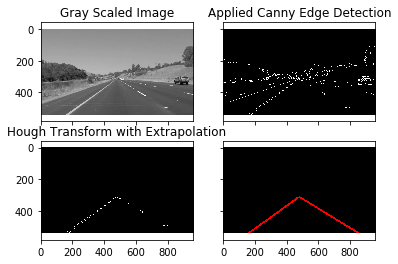

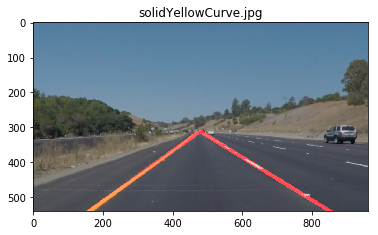

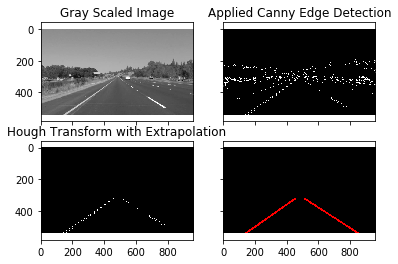

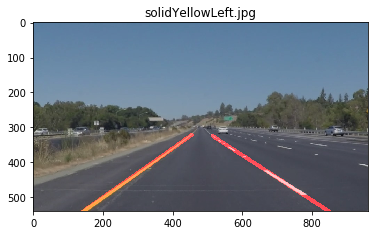

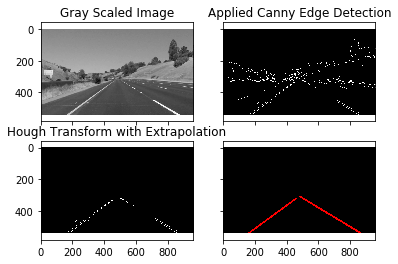

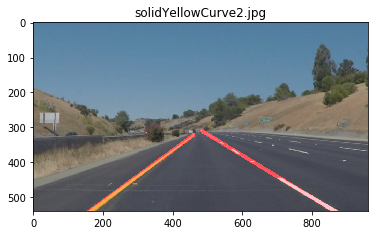

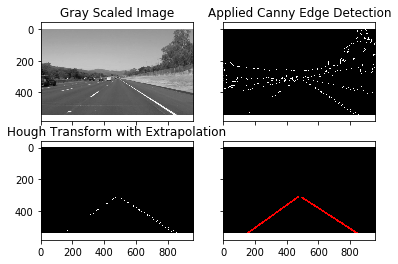

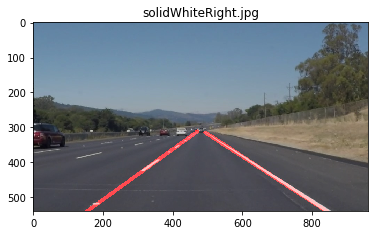

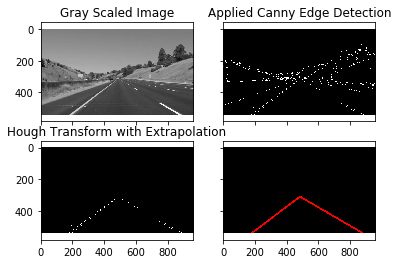

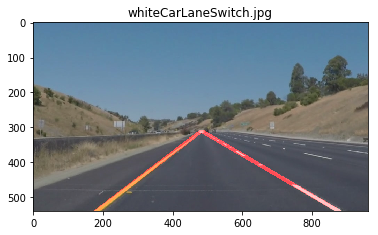

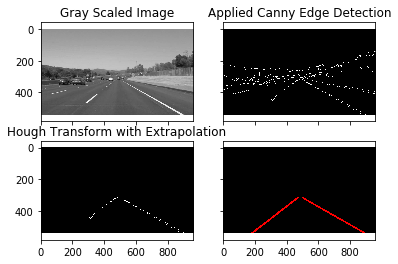

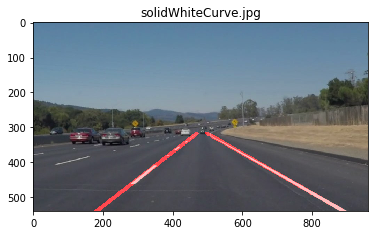

In [166]:
if __name__ == '__main__':
    DEBUG_MODE=False
    test_image_list=os.listdir("test_images/")
    for image_obj in test_image_list:
        if image_obj!=".DS_Store":
            #reading in an image
            image = mpimg.imread('test_images/'+image_obj)
            #printing out some stats and plotting
            print('Processing:', image_obj, 'with dimensions:', image.shape)
            image_copy = image.copy()
            imshape = image_copy.shape
            mask_points = np.array([[0,imshape[0]],[470, 315], [490, 315], [imshape[1],imshape[0]]])
            mask_points=np.int32([mask_points])
            result=process_image(image_copy)
            mpimg.imsave("test_images_output/"+image_obj, result)
            plt.figure()
            plt.imshow(result)
            plt.title(image_obj)


### Lane detection - Videos
Lane detection is applied to the videos present in the **test_video** folder and the output is written to **test_videos_output** directory

In [ ]:
test_videos_list=os.listdir("test_videos/")
for video_obj in test_videos_list:
    if video_obj!=".DS_Store":
        video_output = 'test_videos_output/'+video_obj
        ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
        ## To do so add .subclip(start_second,end_second) to the end of the line below
        ## Where start_second and end_second are integer values representing the start and end of the subclip
        ## You may also uncomment the following line for a subclip of the first 5 seconds
        ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
        clip1 = VideoFileClip("test_videos/"+video_obj)
        white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
        %time white_clip.write_videofile(video_output, audio=False)

#Will Display the last video
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(video_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:57<00:00,  4.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 47.7 s, sys: 2.3 s, total: 50 s
Wall time: 58.3 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [02:40<00:00,  4.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 2min 19s, sys: 5.84 s, total: 2min 25s
Wall time: 2min 41s


### Conclusion
Thus, we successfully apply various image processing techniques in a pipeline to mark the driving lanes in a color agnostic manner within the region of interest.

### Current Shortcomings / Future Improvements
- Be robust to image size.
- Be robust to image resolution.
- Differentiate Snow trails from Lane Markings.
- Alter the algorith to work on sharp curves / hairpin bends.
- Be robust to the alignment of camera.
- To to determine the vertices of ROI polygon automatically.
- Identify other markings within the lane.